# Identify US Mask

Demo file to identify the ultrasound mask from the MRI data.

In [1]:
%load_ext autoreload
%autoreload 2

In [100]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

In [3]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

In [119]:
def voxel_to_world(idx_ijk: np.ndarray, affine: np.ndarray) -> np.ndarray:
    ijk1 = np.concatenate((idx_ijk, [1.0]))
    xyz1 = affine.dot(ijk1)
    return xyz1[:3]

def world_to_voxel(xyz: np.ndarray, affine: np.ndarray) -> np.ndarray:
    inv_aff = np.linalg.inv(affine)
    xyz1 = np.concatenate((xyz, [1.0]))
    ijk1 = inv_aff.dot(xyz1)
    return ijk1[:3]

def mri_to_us_point(i_mri: int,
                      j_mri: int,
                      slice_idx: int,
                      T1_vol: np.ndarray,
                      T1_affine: np.ndarray,
                      US_vol: np.ndarray,
                      US_affine: np.ndarray):
    D_t1, H_t1, W_t1 = T1_vol.shape
    if not (0 <= slice_idx < W_t1 and 0 <= i_mri < D_t1 and 0 <= j_mri < H_t1):
        raise ValueError(f"T1 : indices are out of range (i={i_mri}, j={j_mri}, k={slice_idx})")
    mri_idx_3d = np.array([i_mri, j_mri, slice_idx])
    world_pt = voxel_to_world(mri_idx_3d, T1_affine)
    us_idx_f = world_to_voxel(world_pt, US_affine)
    us_idx = np.round(us_idx_f).astype(int)
    _, _, k_us = us_idx
    us_slice = US_vol[:, :, k_us]  # axial slice in US (H_us × W_us)

    return us_slice, us_idx

def plot_mri_us_aligned(i_mri: int, j_mri: int, slice_idx: int, T1_vol: np.ndarray, us_slice: np.ndarray, us_idx: np.ndarray):  
    t1_slice = T1_vol[:, :, slice_idx]
    i_us, j_us, k_us = us_idx
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(t1_slice, cmap='gray', origin='lower')
    axes[0].plot(j_mri, i_mri, 'ro', markersize=6)
    axes[0].set_title(f"T1 – slice k={slice_idx}")
    axes[0].axis('off')

    axes[1].imshow(us_slice, cmap='gray', origin='lower')
    axes[1].plot(j_us, i_us, 'ro', markersize=6)
    axes[1].set_title(f"US  – slice k={k_us}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



def compute_us_apex_and_direction(m_left, b_left, m_right, b_right):
    # Compute intersection point (apex)
    if np.isclose(m_left, m_right):
        raise RuntimeError("The slopes are nearly equal; no defined intersection.")
    x0 = (b_right - b_left) / (m_left - m_right)
    y0 = m_left * x0 + b_left

    # Compute direction vectors pointing INTO the cone from apex
    v_left = np.array([-1, -m_left])  # Left ray: left/down direction
    v_right = np.array([1, m_right])   # Right ray: right/down direction

    # Normalize vectors
    u_left = v_left / np.linalg.norm(v_left)
    u_right = v_right / np.linalg.norm(v_right)

    # Compute opening angle between rays
    dot_product = np.dot(u_left, u_right)
    dot_product = np.clip(dot_product, -1.0, 1.0)  # Avoid numerical issues
    opening_angle = np.arccos(dot_product)

    # Compute bisector direction (mean of unit vectors)
    bisector = u_left + u_right
    bisector /= np.linalg.norm(bisector)  # Normalize

    return {
        "apex": (x0, y0),
        "opening_angle": opening_angle,
        "direction_vector": bisector
    }

def plot_us_with_affine_lines(us_slice: np.ndarray,
                              m_left: float, b_left: float,
                              m_right: float, b_right: float):
    _, W = us_slice.shape
    plt.figure(figsize=(6, 6))
    plt.imshow(us_slice, cmap="gray", origin="lower")
    plt.title("US slice with affine lines to adjust")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    x_vals = np.array([0, W-1])
    plt.plot(x_vals, m_left*x_vals + b_left, 'c--', linewidth=2)
    plt.plot(x_vals, m_right*x_vals + b_right, 'm--', linewidth=2)
    plt.axis('off')
    plt.show()

def overlay_cone(us_slice: np.ndarray,
                    apex: np.ndarray,
                    direction_vector: np.ndarray,
                    opening_angle: float):
    H, W = us_slice.shape
    x0, y0 = apex
    
    # Create coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0
    norm_v = np.sqrt(vx**2 + vy**2) + 1e-8  # Avoid division by zero
    
    # Unit vectors
    ux = vx / norm_v
    uy = vy / norm_v
    
    # Dot product with cone direction
    dx, dy = direction_vector
    dot = ux*dx + uy*dy
    
    # Cone mask (points within half-angle of bisector)
    half_angle = opening_angle / 2.0
    mask_cone = dot >= np.cos(half_angle)
    
    return mask_cone

def plot_overlay_cone(us_slice: np.ndarray, mask_cone: np.ndarray):
    H, W = us_slice.shape
    overlay = np.zeros((H, W, 4), dtype=float)
    overlay[..., 0] = 1  # Red channel
    overlay[..., 3] = mask_cone * 0.3  # Alpha channel (30% opacity)

    plt.figure(figsize=(6, 6))
    plt.imshow(us_slice, cmap="gray", origin="lower")
    plt.imshow(overlay, origin="lower")
    plt.title("US slice with cone overlay")
    plt.axis('off')
    plt.show()

def cone_us_to_mri_world(
        apex_us_vox,           # (x, y, z) in US voxel coordinates
        direction_vec_us_2d,   # (dx, dy) in US voxel space (2D)
        US_affine,             # 4x4
        T1_affine              # 4x4
    ):

    # Transform apex from US voxel to MRI voxel coordinates
    apex_world = voxel_to_world(apex_us_vox, US_affine)  # Convert to world coordinates
    apex_t1_vox = world_to_voxel(apex_world, T1_affine)  # Convert to MRI voxel coordinates

    # Transform direction vector (rotation only, no translation)
    # Extract rotation matrices from affines (3x3 top-left)
    R_us = US_affine[:3, :3]
    R_t1 = T1_affine[:3, :3]

    # Apply rotation transformations: MRI_dir = (R_t1 @ inv(R_us)) @ US_dir
    direction_vec_3d = np.append(direction_vec_us_2d, 0)  # Convert 2D to 3D (z=0)
    rotated_dir = np.linalg.inv(R_us) @ direction_vec_3d  # Undo US rotation
    direction_vec_t1 = R_t1 @ rotated_dir  # Apply MRI rotation
    direction_vec_t1 = direction_vec_t1[:2] / np.linalg.norm(direction_vec_t1[:2])  # Normalize 2D

    return apex_t1_vox, direction_vec_t1

def plot_median_line(us_slice, apex, direction_vector, d1, d2):
    x0, y0 = apex
    dx, dy = direction_vector
    
    # Calculate segment endpoints
    p1 = (x0 + d1 * dx, y0 + d1 * dy)
    p2 = (x0 + d2 * dx, y0 + d2 * dy)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(us_slice, cmap='gray', origin='lower')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    # Plot full median line (dashed)
    plt.axline((x0, y0), slope=dy/dx if dx != 0 else 1e10, 
               color='cyan', linestyle='--', alpha=0.5)
    
    # Plot selected segment
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 
             'r-', linewidth=3, label=f'd1={d1}, d2={d2}')
    
    # Mark apex and endpoints
    plt.scatter(p1[0], p1[1], s=80, c='lime', marker='o', label='Start')
    plt.scatter(p2[0], p2[1], s=80, c='red', marker='o', label='End')
    
    
    plt.title("Ultrasound Median Line")
    plt.legend()
    plt.axis('off')
    plt.show()



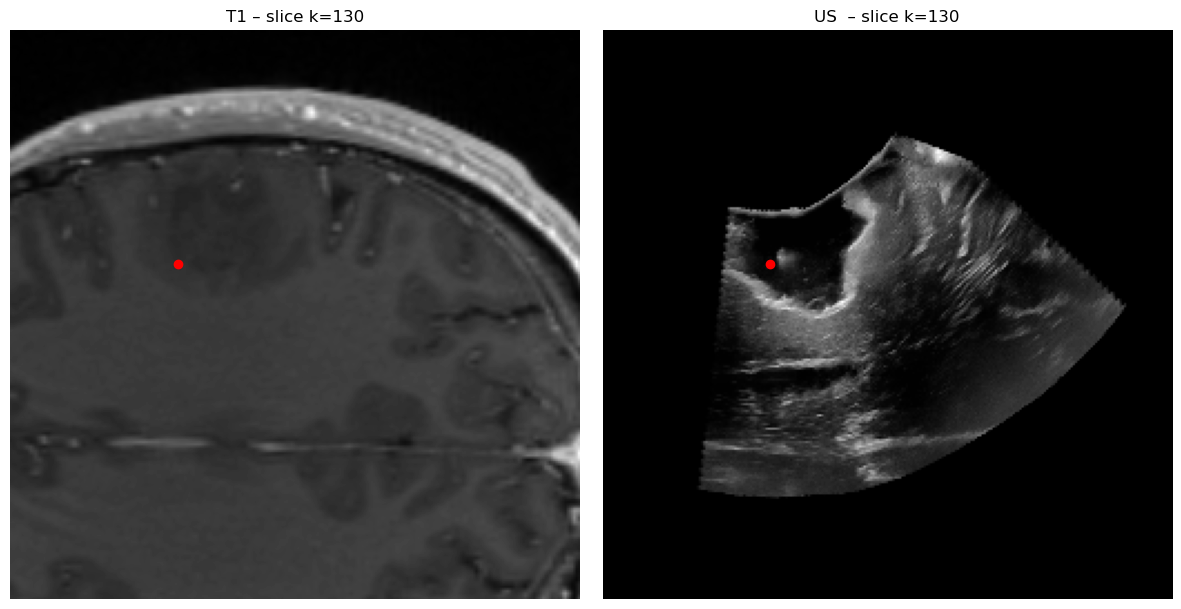

In [75]:
i_mri, j_mri, slice_idx = 150, 75, 130 # Example indices for T1 MRI
us_slice, us_idx = mri_to_us_point(i_mri, j_mri, slice_idx, T1_vol, T1_affine, US_vol, US_affine)
plot_mri_us_aligned(i_mri, j_mri, slice_idx, T1_vol, us_slice, us_idx)

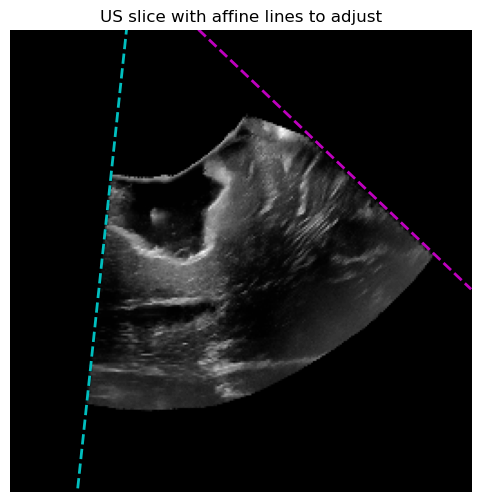

In [78]:
# US edges parameters
mL, bL = 9.4, -350  # Left edge line parameters (slope, intercept)
mR, bR = -0.9524, 355  # Right edge line parameters (slope, intercept)
# mL, bL = -0.1, 216
# mR, bR = 1.05, -117
plot_us_with_affine_lines(us_slice, mL, bL, mR, bR)

_, _, k_us = us_idx
H_us, W_us = us_slice.shape

In [79]:
cone_params = compute_us_apex_and_direction(mL, bL, mR, bR)
x0, y0 = cone_params["apex"]
print("Source :", (x0, y0))
opening_angle   = cone_params["opening_angle"]
direction_vec   = cone_params["direction_vector"]

Source : (68.10015068969514, 290.1414164831343)


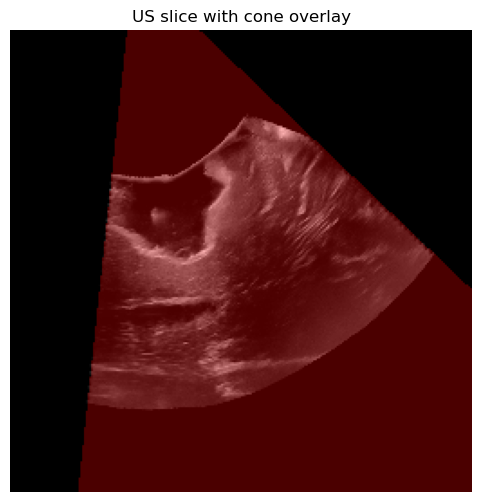

In [95]:
mask_us = overlay_cone(us_slice, apex=np.array([x0, y0]), direction_vector=direction_vec, opening_angle=opening_angle)
plot_overlay_cone(us_slice, mask_us)

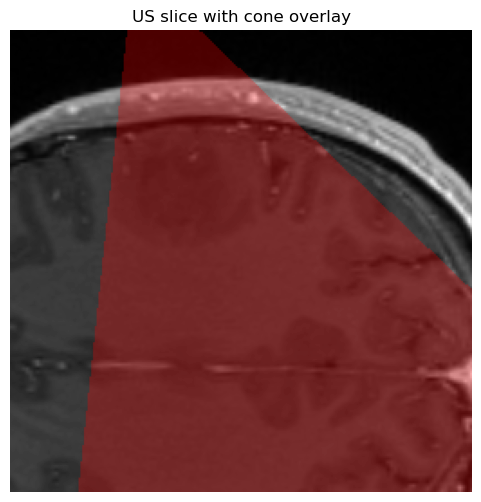

In [97]:
t1_slice = T1_vol[:, :, slice_idx]
H_t1, W_t1 = t1_slice.shape
apex_us_vox = np.array([x0, y0, k_us])

apex_mri_world, direction_mri_world = cone_us_to_mri_world(apex_us_vox, direction_vec, US_affine, T1_affine)

# Visualize result
mask_mri = overlay_cone(t1_slice, apex=apex_mri_world[:2], direction_vector=direction_mri_world, opening_angle=opening_angle)
plot_overlay_cone(t1_slice, mask_mri)

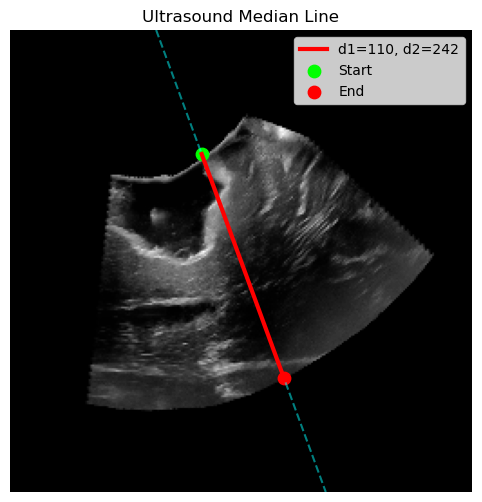

In [118]:
plot_median_line(us_slice, cone_params["apex"], 
                cone_params["direction_vector"], d1=110, d2=242)